<a href="https://colab.research.google.com/github/MikeSirya/Master-Thesis/blob/main/LSTM_Nested_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import tensorflow as tf
import os
import numpy as np

import  tensorflow.keras.losses

In [ ]:
# Specify the path to the CSV file with station codes
csv_path = "/content/SantMateu21.csv"

df = pd.read_csv(csv_path)
df

,Timestamp,Sant Mateu
0,01/01/2021 00:00,2.60
1,01/01/2021 00:10,2.35
2,01/01/2021 00:20,1.80
3,01/01/2021 00:30,1.80
4,01/01/2021 00:40,2.55
...,...,...
21739,31/05/2021 23:10,15.95
21740,31/05/2021 23:20,15.75
21741,31/05/2021 23:30,15.60
21742,31/05/2021 23:40,15.25


In [ ]:
df.index = pd.to_datetime(df['Timestamp'], format= "%d/%m/%Y %H:%M")
df[:5]

,Timestamp,Sant Mateu
Timestamp,,
2021-01-01 00:00:00,01/01/2021 00:00,2.60
2021-01-01 00:10:00,01/01/2021 00:10,2.35
2021-01-01 00:20:00,01/01/2021 00:20,1.80
2021-01-01 00:30:00,01/01/2021 00:30,1.80
2021-01-01 00:40:00,01/01/2021 00:40,2.55


In [ ]:
df.tail()

,Timestamp,Sant Mateu
Timestamp,,
2021-05-31 23:10:00,31/05/2021 23:10,15.95
2021-05-31 23:20:00,31/05/2021 23:20,15.75
2021-05-31 23:30:00,31/05/2021 23:30,15.60
2021-05-31 23:40:00,31/05/2021 23:40,15.25
2021-05-31 23:50:00,31/05/2021 23:50,15.15


In [ ]:
import pandas as pd

# Assuming df is your DataFrame
num_rows = len(df)
print("Number of rows:", num_rows)


Number of rows: 21744


<Axes: xlabel='Timestamp'>

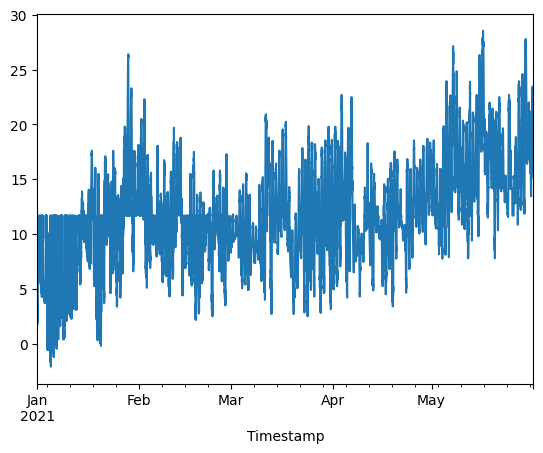

In [ ]:
temp = df['Sant Mateu']
temp.plot()

In [ ]:
# [[[1], [2], [3], [4], [5]]] [6]
# [[[2], [3], [4], [5], [6]]] [7]
# [[[3], [4], [5], [6], [7]]] [8]

def df_to_X_y(df, window_size=5):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [[a] for a in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size]
    y.append(label)
  return np.array(X), np.array(y)

In [ ]:
WINDOW_SIZE = 5
X1, y1 = df_to_X_y(temp, WINDOW_SIZE)
X1.shape, y1.shape

((21739, 5, 1), (21739,))

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

# Assuming you have already defined your df_to_X_y function and loaded your data

# Features (X) and Target Variable (y) using df_to_X_y
WINDOW_SIZE = 5
X, y = df_to_X_y(temp, WINDOW_SIZE)

# Nested Cross-Validation
tscv_outer = TimeSeriesSplit(n_splits=5)
tscv_inner = TimeSeriesSplit(n_splits=3)

param_grid = {'n_estimators': [10, 50, 100], 'max_depth': [None, 10, 20]}

outer_scores = []

for train_outer, test_outer in tscv_outer.split(X):
    X_train_outer, X_test_outer = X[train_outer], X[test_outer]
    y_train_outer, y_test_outer = y[train_outer], y[test_outer]

    inner_scores = []

    for train_inner, val_inner in tscv_inner.split(X_train_outer):
        X_train_inner, X_val_inner = X_train_outer[train_inner], X_train_outer[val_inner]
        y_train_inner, y_val_inner = y_train_outer[train_inner], y_train_outer[val_inner]

        # Reshape the input data for LSTM
        X_train_inner_reshaped = X_train_inner.reshape(X_train_inner.shape[0], X_train_inner.shape[1], 1)
        X_val_inner_reshaped = X_val_inner.reshape(X_val_inner.shape[0], X_val_inner.shape[1], 1)

        # Build and compile the model
        model1 = Sequential()
        model1.add(InputLayer((5, 1)))
        model1.add(LSTM(64))
        model1.add(Dense(8, 'relu'))
        model1.add(Dense(1, 'linear'))

        model1.compile(optimizer=Adam(), loss=MeanSquaredError(), metrics=[RootMeanSquaredError()])

        # Train the model on the inner training set
        model1.fit(
            X_train_inner_reshaped, y_train_inner,
            epochs=10,  # Adjust the number of epochs
            batch_size=32,  # Adjust the batch size
            verbose=0  # Adjust verbosity as needed
        )

        # Evaluate the model on the inner validation set
        X_val_inner_reshaped = X_val_inner.reshape(X_val_inner.shape[0], X_val_inner.shape[1], 1)
        y_pred_val = model1.predict(X_val_inner_reshaped)

        mse_inner = mean_squared_error(y_val_inner, y_pred_val)
        inner_scores.append(mse_inner)

    # Get the mean inner score for hyperparameter tuning
    mean_inner_score = np.mean(inner_scores)

    # Flatten the X_test_outer array for final evaluation
    X_test_outer_reshaped = X_test_outer.reshape(X_test_outer.shape[0], X_test_outer.shape[1], 1)

    # Evaluate the model on the outer test set
    y_pred_outer = model1.predict(X_test_outer_reshaped)

    # Calculate the mean squared error for the outer fold
    mse_outer = mean_squared_error(y_test_outer, y_pred_outer)

    print(f'Mean Squared Error for Outer Fold: {mse_outer}')

    # Store the outer score for aggregation
    outer_scores.append(mse_outer)

# Calculate and print the overall performance across all outer folds
print(f'Overall Mean Squared Error: {np.mean(outer_scores)}')


114/114 [==============================] - 0s 3ms/step
Mean Squared Error for Outer Fold: 2.2126613953048064
114/114 [==============================] - 0s 2ms/step
Mean Squared Error for Outer Fold: 0.21532424273401105
114/114 [==============================] - 0s 4ms/step
Mean Squared Error for Outer Fold: 0.23431415376719736
114/114 [==============================] - 0s 3ms/step
Mean Squared Error for Outer Fold: 0.13048992471708962
114/114 [==============================] - 0s 2ms/step
Mean Squared Error for Outer Fold: 0.3342041108470851
Overall Mean Squared Error: 0.6253987654740378


In [ ]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

In [ ]:
# Save the trained model
model1.save('/content/model1')

# Load the saved model
loaded_model = load_model('/content/model1')



In [ ]:
from math import sqrt
from sklearn.metrics import mean_squared_error
train_predictions = loaded_model.predict(X_train_inner_reshaped).flatten()
train_rmse = sqrt(mean_squared_error(y_train_inner, train_predictions))
train_results = pd.DataFrame(data={'Actuals':y_train_inner,'Train Predictions':train_predictions, 'RMSE': [train_rmse] * len(y_train_inner)})
train_results

425/425 [==============================] - 1s 2ms/step


,Actuals,Train Predictions,RMSE
0,3.40,2.720726,0.819974
1,3.60,3.624147,0.819974
2,3.20,4.207359,0.819974
3,2.70,3.717232,0.819974
4,2.50,3.173035,0.819974
...,...,...,...
13582,6.80,6.348512,0.819974
13583,7.75,7.153454,0.819974
13584,8.00,7.971037,0.819974
13585,7.95,8.539897,0.819974


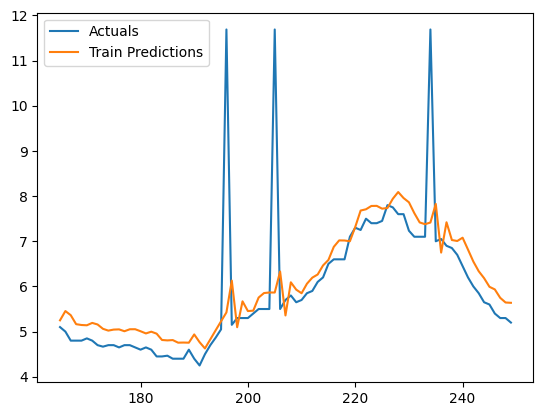

In [ ]:
import matplotlib.pyplot as plt
plt.plot(train_results['Actuals'][165:250], label='Actuals')
plt.plot(train_results['Train Predictions'][165:250], label='Train Predictions')
plt.legend()

In [ ]:
from math import sqrt
from sklearn.metrics import mean_squared_error
val_predictions = loaded_model.predict(X_val_inner_reshaped).flatten()
val_rmse = sqrt(mean_squared_error(y_val_inner, val_predictions))
val_results = pd.DataFrame(data={'Actuals':y_val_inner,'val Predictions':val_predictions, 'RMSE': [val_rmse] * len(y_val_inner)})
val_results

142/142 [==============================] - 0s 2ms/step


,Actuals,val Predictions,RMSE
0,9.55,8.640629,0.355832
1,10.60,9.373786,0.355832
2,12.10,10.510081,0.355832
3,12.45,11.963137,0.355832
4,12.50,12.806792,0.355832
...,...,...,...
4524,19.85,20.872046,0.355832
4525,19.55,20.186724,0.355832
4526,19.60,19.706488,0.355832
4527,19.45,19.559132,0.355832


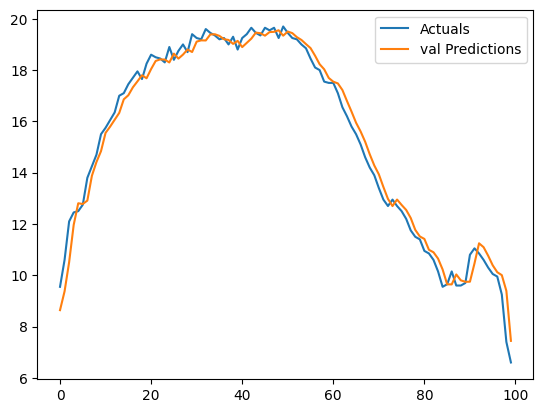

In [ ]:
plt.plot(val_results['Actuals'][:100], label='Actuals')
plt.plot(val_results['val Predictions'][:100],label='val Predictions' )

plt.legend()

In [ ]:
from math import sqrt
from sklearn.metrics import mean_squared_error
test_predictions = loaded_model.predict( X_test_outer_reshaped).flatten()
test_rmse = sqrt(mean_squared_error(y_test_outer, test_predictions))
test_results = pd.DataFrame(data={'Actuals':y_test_outer,'Test Predictions':test_predictions, 'RMSE': [test_rmse] * len(y_test_outer)})
test_results

114/114 [==============================] - 0s 2ms/step


,Actuals,Test Predictions,RMSE
0,19.10,19.162174,0.578104
1,18.70,19.055195,0.578104
2,18.70,18.785780,0.578104
3,18.60,18.673018,0.578104
4,18.50,18.569075,0.578104
...,...,...,...
3618,15.95,16.269993,0.578104
3619,15.75,16.027735,0.578104
3620,15.60,15.829579,0.578104
3621,15.25,15.651151,0.578104


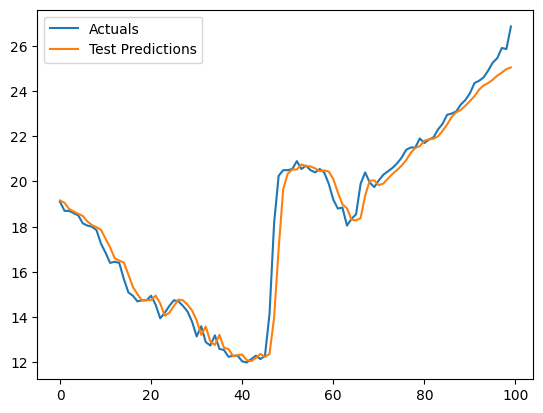

In [ ]:
plt.plot(test_results['Actuals'][:100], label='Actuals')
plt.plot(test_results['Test Predictions'][:100],label='Test Predictions' )

plt.legend()

In [ ]:
# Specify the path to the CSV file with station codes
csv_path = "/content/SantMateu22.csv"

val_df = pd.read_csv(csv_path)
val_df



,Timestamp,Sant Mateu
0,01/01/2021 00:00,6.15
1,01/01/2021 00:10,6.70
2,01/01/2021 00:20,6.85
3,01/01/2021 00:30,6.65
4,01/01/2021 00:40,6.55
...,...,...
21739,31/05/2021 23:10,17.75
21740,31/05/2021 23:20,17.80
21741,31/05/2021 23:30,17.70
21742,31/05/2021 23:40,16.45


In [ ]:
val_df.index = pd.to_datetime(val_df['Timestamp'], format= "%d/%m/%Y %H:%M")
val_df[:5]

,Timestamp,Sant Mateu
Timestamp,,
2021-01-01 00:00:00,01/01/2021 00:00,6.15
2021-01-01 00:10:00,01/01/2021 00:10,6.70
2021-01-01 00:20:00,01/01/2021 00:20,6.85
2021-01-01 00:30:00,01/01/2021 00:30,6.65
2021-01-01 00:40:00,01/01/2021 00:40,6.55


<Axes: xlabel='Timestamp'>

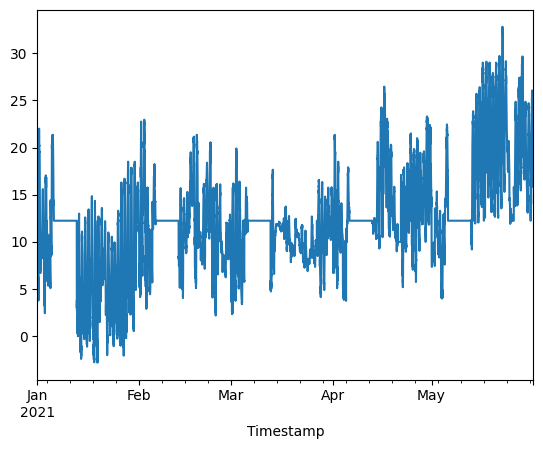

In [ ]:
val_df = val_df['Sant Mateu']
val_df.plot()

In [ ]:
# Assuming df_toX_y function extracts features (X) from the new data
WINDOW_SIZE = 5
X_new_data, y_new_data = df_to_X_y(val_df, WINDOW_SIZE)
# Access the shape of the features
X_new_data.shape, y_new_data.shape

((21739, 5, 1), (21739,))

In [ ]:
from math import sqrt
from sklearn.metrics import mean_squared_error
Predictions = loaded_model.predict(X_new_data).flatten()
rmse1 = sqrt(mean_squared_error(y_new_data, Predictions))
Results = pd.DataFrame(data={'Actuals':y_new_data,'Predictions':Predictions, 'RMSE': [rmse1] * len(y_new_data)})
Results

680/680 [==============================] - 2s 3ms/step


,Actuals,Predictions,RMSE
0,6.20,6.951601,0.64242
1,6.35,6.567713,0.64242
2,6.15,6.650549,0.64242
3,6.10,6.511986,0.64242
4,6.30,6.449891,0.64242
...,...,...,...
21734,17.75,18.534758,0.64242
21735,17.80,17.995882,0.64242
21736,17.70,17.815855,0.64242
21737,16.45,17.689844,0.64242


Text(0.5, 1.0, 'NESTED LSTM MODEL1 ')

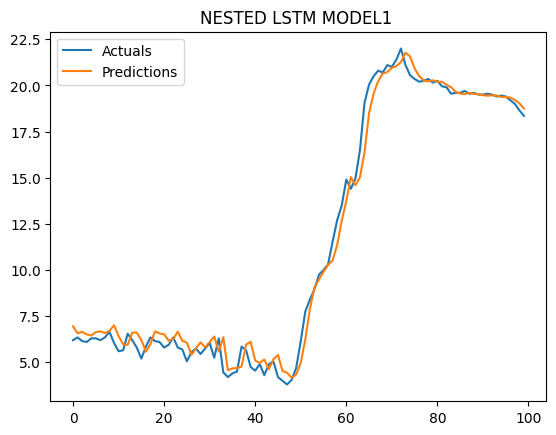

In [ ]:
import matplotlib.pyplot as plt
plt.plot(Results['Actuals'][:100], label='Actuals')
plt.plot(Results['Predictions'][:100], label='Predictions')
plt.legend()
plt.title('NESTED LSTM MODEL1 ')

In [ ]:
# Specify the path to the CSV file with station codes
csv_path = "/content/La jana la Pedrera22.csv"

val_df2 = pd.read_csv(csv_path)
val_df2



,Timestamp,la Jana - la Pedrera
0,01/01/2021 00:00,10.2
1,01/01/2021 00:10,10.1
2,01/01/2021 00:20,10.8
3,01/01/2021 00:30,11.3
4,01/01/2021 00:40,11.1
...,...,...
21739,31/05/2021 23:10,20.3
21740,31/05/2021 23:20,19.9
21741,31/05/2021 23:30,19.6
21742,31/05/2021 23:40,19.4


In [ ]:
val_df2.index = pd.to_datetime(val_df2['Timestamp'], format= "%d/%m/%Y %H:%M")
val_df2[:5]

,Timestamp,la Jana - la Pedrera
Timestamp,,
2021-01-01 00:00:00,01/01/2021 00:00,10.2
2021-01-01 00:10:00,01/01/2021 00:10,10.1
2021-01-01 00:20:00,01/01/2021 00:20,10.8
2021-01-01 00:30:00,01/01/2021 00:30,11.3
2021-01-01 00:40:00,01/01/2021 00:40,11.1


<Axes: xlabel='Timestamp'>

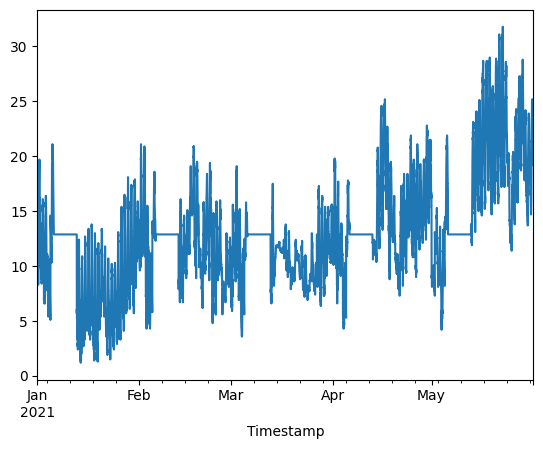

In [ ]:
val_df2 = val_df2['la Jana - la Pedrera']
val_df2.plot()

In [ ]:
import pandas as pd

# Assuming df is your DataFrame
num_rows = len(val_df2)
print("Number of rows:", num_rows)
val_df2.tail()

Number of rows: 21744


Timestamp
2021-05-31 23:10:00    20.3
2021-05-31 23:20:00    19.9
2021-05-31 23:30:00    19.6
2021-05-31 23:40:00    19.4
2021-05-31 23:50:00    19.2
Name: la Jana - la Pedrera, dtype: float64

In [ ]:
# Assuming df_toX_y function extracts features (X) from the new data
WINDOW_SIZE = 5
X_new_data2, y_new_data2 = df_to_X_y(val_df2, WINDOW_SIZE)
# Access the shape of the features
X_new_data2.shape, y_new_data2.shape

((21739, 5, 1), (21739,))

In [ ]:
from math import sqrt
from sklearn.metrics import mean_squared_error
Predictions2 = loaded_model.predict(X_new_data2).flatten()
rmse2 = sqrt(mean_squared_error(y_new_data2, Predictions2))
Results2 = pd.DataFrame(data={'Actuals':y_new_data2,'Predictions':Predictions2, 'RMSE': [rmse2] * len(y_new_data2)})
Results2

680/680 [==============================] - 2s 3ms/step


,Actuals,Predictions,RMSE
0,10.6,11.312226,0.51179
1,11.0,10.751432,0.51179
2,11.7,11.038239,0.51179
3,12.1,11.675753,0.51179
4,11.2,12.259117,0.51179
...,...,...,...
21734,20.3,20.513384,0.51179
21735,19.9,20.380442,0.51179
21736,19.6,20.067345,0.51179
21737,19.4,19.723885,0.51179


In [ ]:
# Specify the path to the CSV file with station codes
csv_path = "/content/Castellon Bayanat22.csv"

val_df3 = pd.read_csv(csv_path)
val_df3



,Timestamp,Castelló de la Plana - IES Vicent Sos Baynat
0,01/01/2021 00:00,9.7
1,01/01/2021 00:10,9.5
2,01/01/2021 00:20,9.3
3,01/01/2021 00:30,9.3
4,01/01/2021 00:40,9.1
...,...,...
21739,31/05/2021 23:10,21.3
21740,31/05/2021 23:20,21.2
21741,31/05/2021 23:30,21.2
21742,31/05/2021 23:40,21.3


In [ ]:
val_df3.index = pd.to_datetime(val_df3['Timestamp'], format= "%d/%m/%Y %H:%M")
val_df3[:5]

,Timestamp,Castelló de la Plana - IES Vicent Sos Baynat
Timestamp,,
2021-01-01 00:00:00,01/01/2021 00:00,9.7
2021-01-01 00:10:00,01/01/2021 00:10,9.5
2021-01-01 00:20:00,01/01/2021 00:20,9.3
2021-01-01 00:30:00,01/01/2021 00:30,9.3
2021-01-01 00:40:00,01/01/2021 00:40,9.1


<Axes: xlabel='Timestamp'>

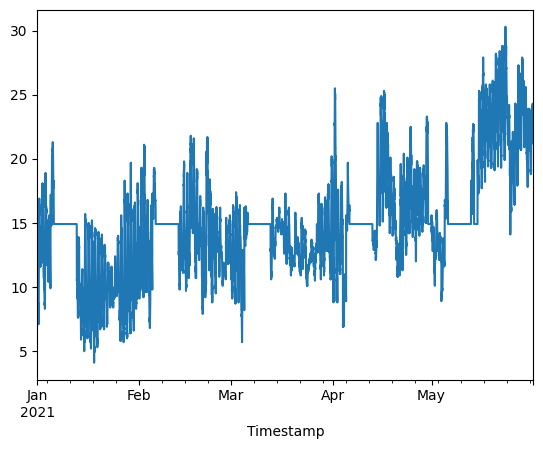

In [ ]:
val_df3 = val_df3['Castelló de la Plana - IES Vicent Sos Baynat']
val_df3.plot()

In [ ]:
import pandas as pd

# Assuming df is your DataFrame
num_rows = len(val_df3)
print("Number of rows:", num_rows)
val_df3.tail()

Number of rows: 21744


Timestamp
2021-05-31 23:10:00    21.3
2021-05-31 23:20:00    21.2
2021-05-31 23:30:00    21.2
2021-05-31 23:40:00    21.3
2021-05-31 23:50:00    21.2
Name: Castelló de la Plana - IES Vicent Sos Baynat, dtype: float64

In [ ]:
# Assuming df_toX_y function extracts features (X) from the new data
WINDOW_SIZE = 5
X_new_data3, y_new_data3 = df_to_X_y(val_df3, WINDOW_SIZE)
# Access the shape of the features
X_new_data3.shape, y_new_data3.shape

((21739, 5, 1), (21739,))

In [ ]:
from math import sqrt
from sklearn.metrics import mean_squared_error
Predictions3 = loaded_model.predict(X_new_data3).flatten()
rmse3 = sqrt(mean_squared_error(y_new_data3, Predictions3))
Results3 = pd.DataFrame(data={'Actuals':y_new_data3,'Predictions3':Predictions, 'RMSE': [rmse3] * len(y_new_data3)})
Results3

680/680 [==============================] - 2s 2ms/step


,Actuals,Predictions3,RMSE
0,8.8,6.951601,0.403935
1,8.4,6.567713,0.403935
2,8.1,6.650549,0.403935
3,8.2,6.511986,0.403935
4,8.3,6.449891,0.403935
...,...,...,...
21734,21.3,18.534758,0.403935
21735,21.2,17.995882,0.403935
21736,21.2,17.815855,0.403935
21737,21.3,17.689844,0.403935


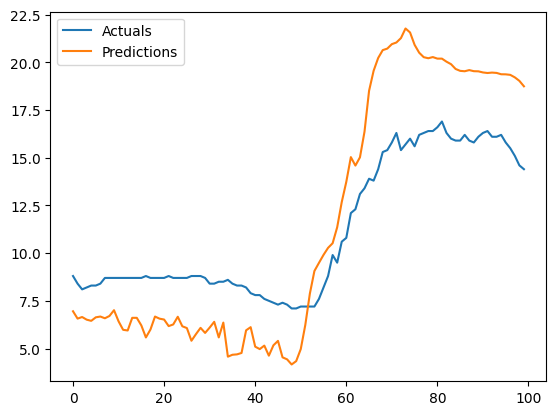

In [ ]:
import matplotlib.pyplot as plt
plt.plot(Results3['Actuals'][:100], label='Actuals')
plt.plot(Results3['Predictions3'][:100], label='Predictions')
plt.legend()

In [ ]:
# Specify the path to the CSV file with station codes
csv_path = "/content/Forcall22.csv"

val_df4 = pd.read_csv(csv_path)
val_df4



,Timestamp,Forcall
0,01/01/2021 00:00,2.8
1,01/01/2021 00:10,2.3
2,01/01/2021 00:20,2.2
3,01/01/2021 00:30,2.4
4,01/01/2021 00:40,2.5
...,...,...
21739,31/05/2021 23:10,17.6
21740,31/05/2021 23:20,17.3
21741,31/05/2021 23:30,17.1
21742,31/05/2021 23:40,16.9


In [ ]:
val_df4.index = pd.to_datetime(val_df4['Timestamp'], format= "%d/%m/%Y %H:%M")
val_df4[:5]

,Timestamp,Forcall
Timestamp,,
2021-01-01 00:00:00,01/01/2021 00:00,2.8
2021-01-01 00:10:00,01/01/2021 00:10,2.3
2021-01-01 00:20:00,01/01/2021 00:20,2.2
2021-01-01 00:30:00,01/01/2021 00:30,2.4
2021-01-01 00:40:00,01/01/2021 00:40,2.5


<Axes: xlabel='Timestamp'>

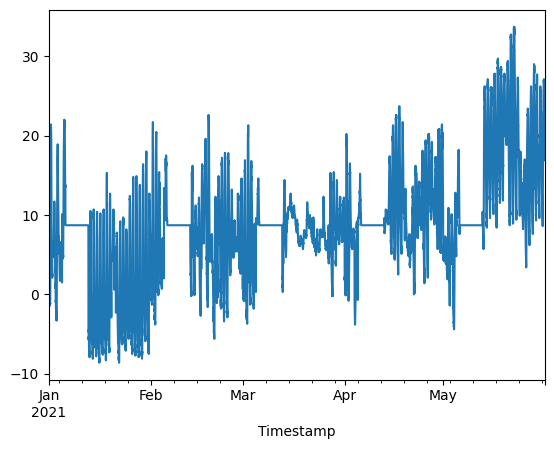

In [ ]:
val_df4 = val_df4['Forcall']
val_df4.plot()

In [ ]:
import pandas as pd

# Assuming df is your DataFrame
num_rows = len(val_df4)
print("Number of rows:", num_rows)
val_df4.tail()

Number of rows: 21744


Timestamp
2021-05-31 23:10:00    17.6
2021-05-31 23:20:00    17.3
2021-05-31 23:30:00    17.1
2021-05-31 23:40:00    16.9
2021-05-31 23:50:00    16.9
Name: Forcall, dtype: float64

In [ ]:
# Assuming df_toX_y function extracts features (X) from the new data
WINDOW_SIZE = 5
X_new_data4, y_new_data4 = df_to_X_y(val_df4, WINDOW_SIZE)
# Access the shape of the features
X_new_data4.shape, y_new_data4.shape

((21739, 5, 1), (21739,))

In [ ]:
from math import sqrt
from sklearn.metrics import mean_squared_error
Predictions4 = loaded_model.predict(X_new_data4).flatten()
rmse4 = sqrt(mean_squared_error(y_new_data4, Predictions4))
Results4 = pd.DataFrame(data={'Actuals':y_new_data4,'Predictions':Predictions4, 'RMSE': [rmse4] * len(y_new_data4)})
Results4

680/680 [==============================] - 2s 3ms/step


,Actuals,Predictions,RMSE
0,2.3,2.848655,1.497583
1,1.9,2.739396,1.497583
2,1.8,2.382311,1.497583
3,1.7,2.237131,1.497583
4,2.0,2.100477,1.497583
...,...,...,...
21734,17.6,17.662416,1.497583
21735,17.3,17.590834,1.497583
21736,17.1,17.380575,1.497583
21737,16.9,17.197897,1.497583


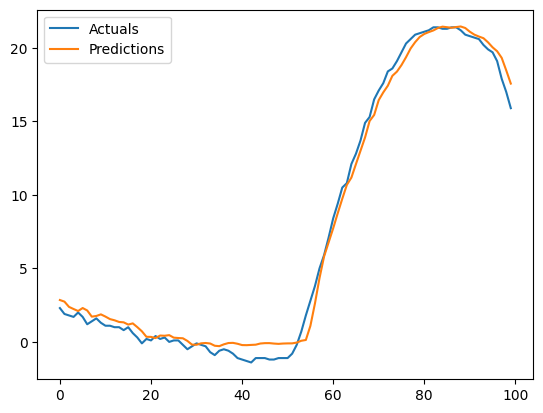

In [ ]:
import matplotlib.pyplot as plt
plt.plot(Results4['Actuals'][:100], label='Actuals')
plt.plot(Results4['Predictions'][:100], label='Predictions')
plt.legend()

In [ ]:
# Specify the path to the CSV file with station codes
csv_path = "/content/Xodos22.csv"

val_df5 = pd.read_csv(csv_path)
val_df5



,Timestamp,Xodos
0,01/01/2021 00:00,16.4
1,01/01/2021 00:10,16.7
2,01/01/2021 00:20,17.1
3,01/01/2021 00:30,17.2
4,01/01/2021 00:40,17.2
...,...,...
21739,31/05/2021 23:10,17.7
21740,31/05/2021 23:20,17.7
21741,31/05/2021 23:30,18.0
21742,31/05/2021 23:40,17.9


In [ ]:
val_df5.index = pd.to_datetime(val_df5['Timestamp'], format= "%d/%m/%Y %H:%M")
val_df5[:5]

,Timestamp,Xodos
Timestamp,,
2021-01-01 00:00:00,01/01/2021 00:00,16.4
2021-01-01 00:10:00,01/01/2021 00:10,16.7
2021-01-01 00:20:00,01/01/2021 00:20,17.1
2021-01-01 00:30:00,01/01/2021 00:30,17.2
2021-01-01 00:40:00,01/01/2021 00:40,17.2


<Axes: xlabel='Timestamp'>

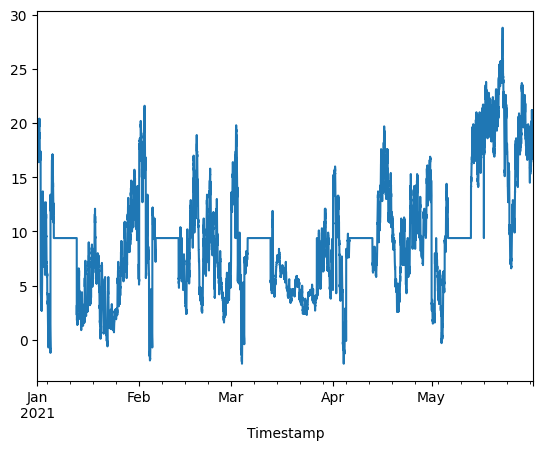

In [ ]:
val_df5 = val_df5['Xodos']
val_df5.plot()

In [ ]:
import pandas as pd

# Assuming df is your DataFrame
num_rows = len(val_df5)
print("Number of rows:", num_rows)
val_df5.tail()

Number of rows: 21744


Timestamp
2021-05-31 23:10:00    17.7
2021-05-31 23:20:00    17.7
2021-05-31 23:30:00    18.0
2021-05-31 23:40:00    17.9
2021-05-31 23:50:00    17.7
Name: Xodos, dtype: float64

In [ ]:
# Assuming df_toX_y function extracts features (X) from the new data
WINDOW_SIZE = 5
X_new_data5, y_new_data5 = df_to_X_y(val_df5, WINDOW_SIZE)
# Access the shape of the features
X_new_data5.shape, y_new_data5.shape

((21739, 5, 1), (21739,))

In [ ]:
from math import sqrt
from sklearn.metrics import mean_squared_error
Predictions5 = loaded_model.predict(X_new_data5).flatten()
rmse5 = sqrt(mean_squared_error(y_new_data5, Predictions5))
Results5 = pd.DataFrame(data={'Actuals':y_new_data5,'Predictions':Predictions5, 'RMSE': [rmse5] * len(y_new_data5)})
Results5

680/680 [==============================] - 2s 3ms/step


,Actuals,Predictions,RMSE
0,17.1,17.179880,0.514664
1,16.9,17.127226,0.514664
2,17.2,16.982084,0.514664
3,17.4,17.131876,0.514664
4,17.2,17.291536,0.514664
...,...,...,...
21734,17.7,17.806322,0.514664
21735,17.7,17.713573,0.514664
21736,18.0,17.684202,0.514664
21737,17.9,17.856298,0.514664


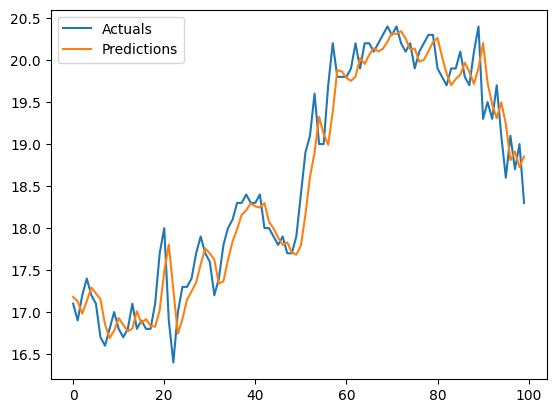

In [ ]:
import matplotlib.pyplot as plt
plt.plot(Results5['Actuals'][:100], label='Actuals')
plt.plot(Results5['Predictions'][:100], label='Predictions')
plt.legend()